## Read CSV file 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
df = pd.read_csv("../../data/malaysia_house_price_data_2025.csv")
df.head()

,Township,Area,State,Tenure,Type,Median_Price,Median_PSF,Transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800,304,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900,322,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954,130,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600,218,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300,168,363


In [3]:
# Average Regional Price (GroupBy Township or State)
# First calculate the average price for each township
township_avg = df.groupby("Township")["Median_Price"].mean().reset_index()
township_avg.rename(columns={"Median_Price": "Township_AvgPrice"}, inplace=True)

# merge with original table
df = df.merge(township_avg, on="Township", how="left")

# state
state_avg = df.groupby("State")["Median_Price"].mean().reset_index()
state_avg.rename(columns={"Median_Price": "State_AvgPrice"}, inplace=True)
df = df.merge(state_avg, on="State", how="left")

# # -------------------
# # price per square foot
# df["Price_per_Sqft"] = df["Median_Price"] / (df["Median_PSF"] + 1e-5)  # avoid value to 0


In [4]:
if "ID" in df.columns:
    df = df.drop("ID", axis=1)
# handle missing value 
df = df.fillna(df.median(numeric_only=True))

# One-hot encoding 
df = pd.get_dummies(df, drop_first=True)
df.head()

,Median_Price,Median_PSF,Transactions,Township_AvgPrice,State_AvgPrice,Township_1 TANJUNG,Township_10 Mont Kiara @ MK10,Township_11 Mont Kiara @ MK11,Township_1120 Park Avenue,Township_18 Madge,...,"Type_Terrace House, Semi D, Bungalow","Type_Terrace House, Semi D, Town House","Type_Terrace House, Town House",Type_Town House,"Type_Town House, Bungalow","Type_Town House, Bungalow, Terrace House","Type_Town House, Semi D","Type_Town House, Semi D, Terrace House","Type_Town House, Terrace House","Type_Town House, Terrace House, Semi D"
0,331800,304,593,331800.0,475844.374332,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,590900,322,519,590900.0,484990.358090,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,229954,130,414,229954.0,328909.932990,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,255600,218,391,255600.0,329528.969388,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,219300,168,363,219300.0,328909.932990,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


define features and target value

In [5]:
X = df.drop(columns=["Median_Price", "Median_PSF", "Transactions"], axis=1)
y = df["Median_Price"]


**Split Dataset**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normlization data

In [7]:
# normalization
scaler = RobustScaler() # reducing the influence of outliers.
X_train = scaler.fit_transform(X=X_train)
X_test = scaler.transform(X=X_test)

In [8]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)
y_pred = model.predict(X=X_test)

## Regularization

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
import numpy as np

models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)  # L1+L2 hybrid
}

# train and evaluation 
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

# cross valuation (Ridge, Lasso, ElasticNet)
scores_lr = cross_val_score(LinearRegression(), X, y, cv=5, scoring="r2")
scores_ridge = cross_val_score(Ridge(alpha=0.3), X, y, cv=5, scoring="r2")
scores_lasso = cross_val_score(Lasso(alpha=0.3), X, y, cv=5, scoring="r2")
scores_enet = cross_val_score(ElasticNet(alpha=0.3, l1_ratio=0.5), X, y, cv=5, scoring="r2")

print("Linear Regression R² scores:", scores_lr)
print("Average Linear Regression R²:", scores_lr.mean())
print("Ridge R² scores:", scores_ridge)
print("Average Ridge R²:", scores_ridge.mean())
print("Lasso R² scores:", scores_lasso)
print("Average Lasso R²:", scores_lasso.mean())
print("ElasticNet R² scores:", scores_enet)
print("Average ElasticNet R²:", scores_enet.mean())

# RidgeCV Hyperparameter Turing 
ridge_cv = RidgeCV(alphas=[0.1, 1, 10, 100]) # type: ignore
ridge_cv.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_cv.alpha_)
print("Ridge Test R²:", ridge_cv.score(X_test, y_test))


LinearRegression: MAE=116865.87, RMSE=169657.08, R²=0.8364


C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.567e+10, tolerance: 3.686e+10
  model = cd_fast.enet_coordinate_descent(


Lasso: MAE=53535.20, RMSE=146040.25, R²=0.8788
Ridge: MAE=14812.01, RMSE=27241.48, R²=0.9958
ElasticNet: MAE=43141.81, RMSE=71158.29, R²=0.9712


C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.37987e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.66002e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.20978e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.71362e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (r

Linear Regression R² scores: [0.91765901 0.91108971 0.84103634 0.90881933 0.86697951]
Average Linear Regression R²: 0.8891167807825584
Ridge R² scores: [0.9618789  0.98433012 0.97676156 0.99442684 0.98659375]
Average Ridge R²: 0.9807982342347683
Lasso R² scores: [0.93545676 0.89778357 0.84878125 0.94586007 0.8750968 ]
Average Lasso R²: 0.9005956910836648
ElasticNet R² scores: [0.97537022 0.9980978  0.9896983  0.99821811 0.99834364]
Average ElasticNet R²: 0.9919456141783792
Best Ridge alpha: 10.0
Ridge Test R²: 0.998087607221016


## Metrics

In [10]:
mae_log = mean_absolute_error(y_test, y_pred=y_pred)
mse_log = mean_squared_error(y_test, y_pred=y_pred)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred=y_pred)

print("MAE:", mae)
print("MSE: ", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 43141.80630511141
MSE:  5063502872.76213
RMSE: 71158.29447620375
R² Score: 0.9712168956886545


## visualization

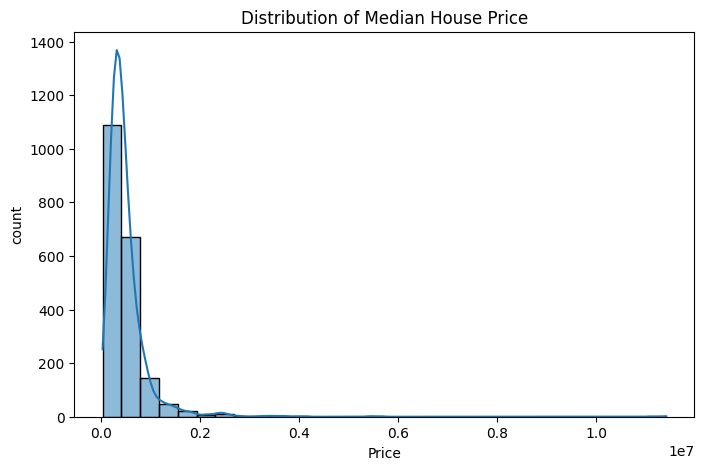

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(data=df["Median_Price"], kde=True, bins=30) # type: ignore
plt.title("Distribution of Median House Price")
plt.xlabel("Price")
plt.ylabel("count")
plt.show()

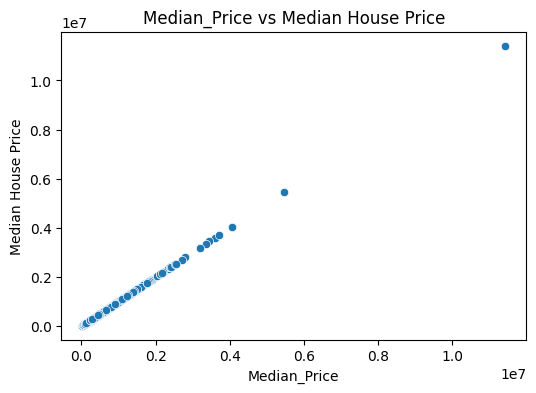

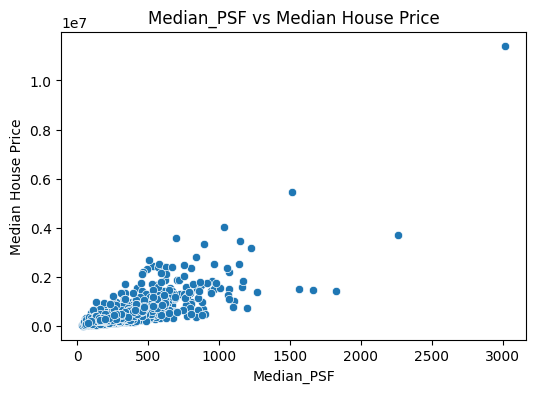

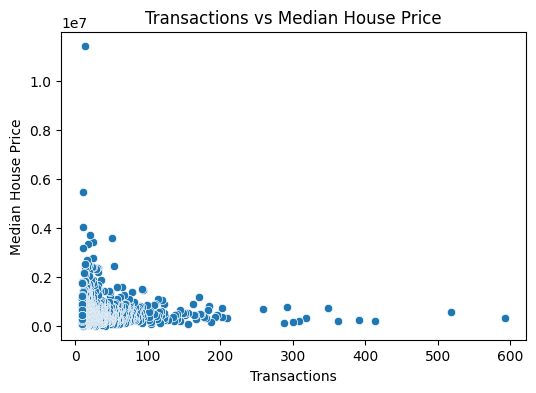

In [12]:
num_features = ["Median_Price", "Median_PSF", "Transactions"]

for feature in num_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df["Median_Price"])
    plt.title(f"{feature} vs Median House Price")
    plt.xlabel(feature)
    plt.ylabel("Median House Price")
    plt.show()

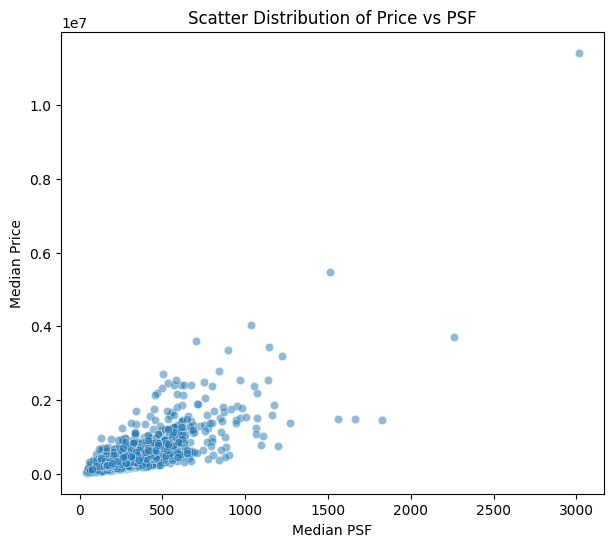

In [13]:
plt.figure(figsize=(7, 6))
sns.scatterplot(x=df["Median_PSF"], y=df["Median_Price"], alpha=0.5)
plt.xlabel("Median PSF")
plt.ylabel("Median Price")
plt.title("Scatter Distribution of Price vs PSF")
plt.show()



C:\Users\yuhan\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.567e+10, tolerance: 3.686e+10
  model = cd_fast.enet_coordinate_descent(


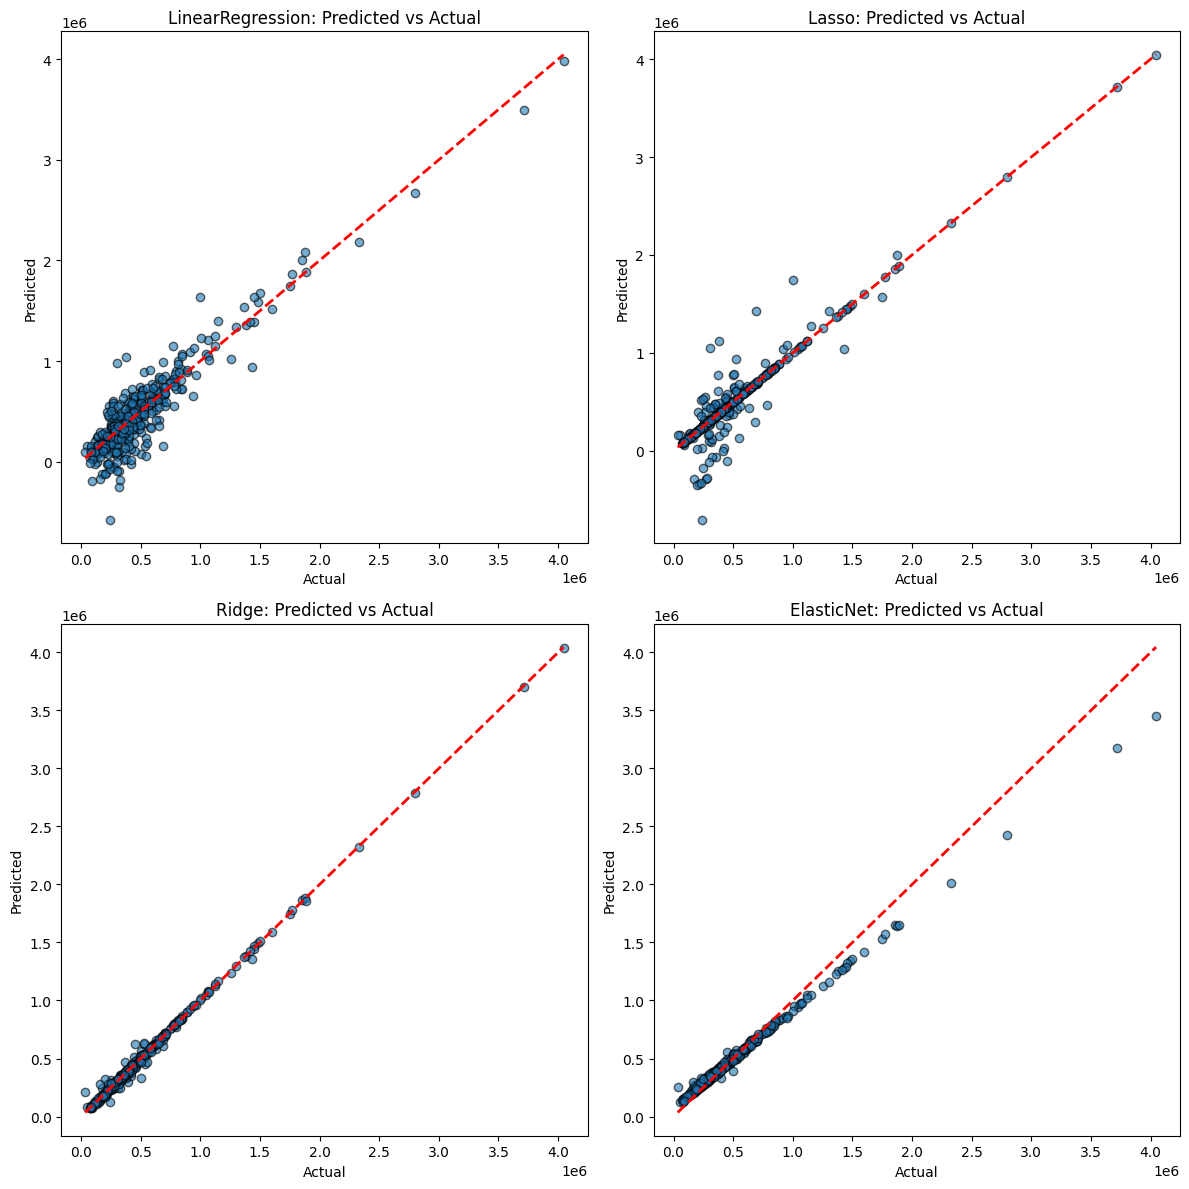

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="k")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{name}: Predicted vs Actual")

plt.tight_layout()
plt.show()
